The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


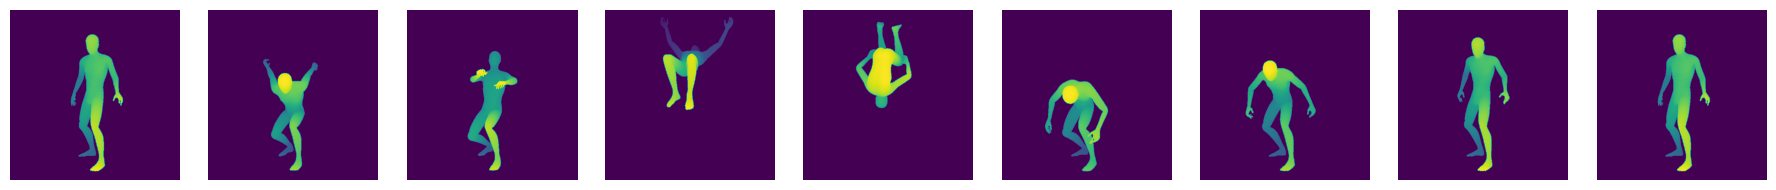

In [10]:
%load_ext autoreload
%autoreload 2

import torch

from text3d2video.artifacts.anim_artifact import AnimationArtifact
from text3d2video.utilities.ipython_utils import display_ims
from text3d2video.rendering import render_depth_map

torch.set_grad_enabled(False)

animation_tag = "backflip:latest"

animation = AnimationArtifact.from_wandb_artifact_tag(animation_tag)
n_frames = 9
frame_indices = animation.frame_indices(n_frames)
cameras, meshes = animation.load_frames(frame_indices)

depths = render_depth_map(meshes, cameras)
display_ims(depths)

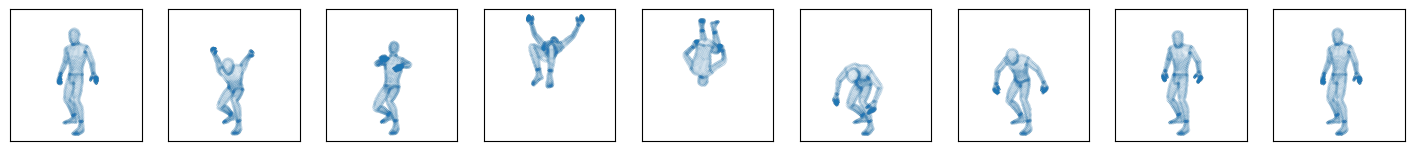

In [11]:
from matplotlib import pyplot as plt
from text3d2video.backprojection import project_visible_verts_to_cameras

visible_vert_coords, visible_vert_indices = project_visible_verts_to_cameras(meshes, cameras)

s = 2
fig, axs = plt.subplots(1, n_frames, figsize=(n_frames * s, s))
for i in range(n_frames):
    ax = axs[i]
    frame_visible_vert_coords = visible_vert_coords[i].cpu()
    ax.scatter(frame_visible_vert_coords[:, 0], frame_visible_vert_coords[:, 1], s=0.001)
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("equal")

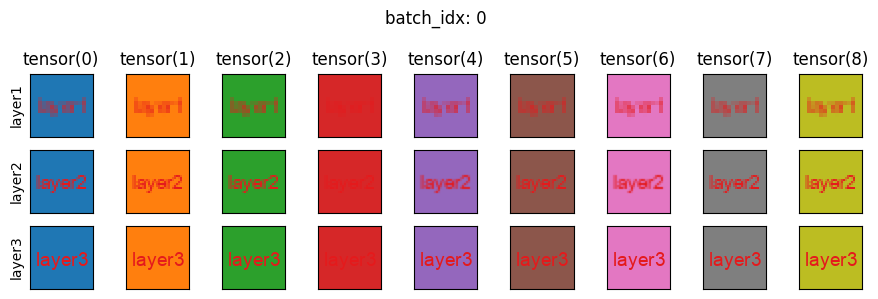

In [44]:
from matplotlib.cm import get_cmap
from text3d2video.utilities.ipython_utils import display_ims_grid
import torchvision.transforms.functional as TF

from visual_tests.testing_utils import test_img


def make_test_diffusion_spatial_features(
    layers: list,
    resolutions: list,
    n_frames: int,
    n_batches: int,
    device="cuda",
    cmap_frame="tab10",
    cmap_batch="Set1",
):
    cmap_frame = get_cmap(cmap_frame)
    cmap_batch = get_cmap(cmap_batch)

    frame_indices = torch.arange(n_frames)
    frame_colors = cmap_frame(frame_indices)
    batch_colors = cmap_batch(torch.arange(n_batches))

    features = {}

    for layer, resolution in zip(layers, resolutions):
        all_ims = []
        for batch in range(n_batches):
            images = [
                test_img(
                    resolution=resolution,
                    color=frame_colors[i][0:3],
                    txt=layer,
                    textcolor=batch_colors[batch][0:3],
                )
                for i in range(n_frames)
            ]
            images = torch.stack([TF.to_tensor(img) for img in images]).to(device)
            all_ims.append(images)

        layer_features = torch.stack(all_ims)

        features[layer] = layer_features

    return features


layers = ["layer1", "layer2", "layer3"]
resolutions = [16, 32, 64]

layer_resolutions = dict(zip(layers, resolutions))

def display_diffusion_spatial_features(features, batch_idx=0, scale=1):
    ims_grid = []
    n_frames = None

    for layer, resolution in zip(layers, resolutions):
        ims = features[layer]
        ims = ims[batch_idx]
        n_frames = ims.shape[0]
        ims = [TF.to_pil_image(im) for im in ims]
        ims_grid.append(ims)

    display_ims_grid(
        ims_grid,
        col_titles=torch.arange(n_frames),
        row_titles=layers,
        scale=scale,
        title=f"batch_idx: {batch_idx}",
    )

diffusion_spatial_features = make_test_diffusion_spatial_features(
    layers, resolutions, n_frames, 2
)

display_diffusion_spatial_features(diffusion_spatial_features, batch_idx=0)

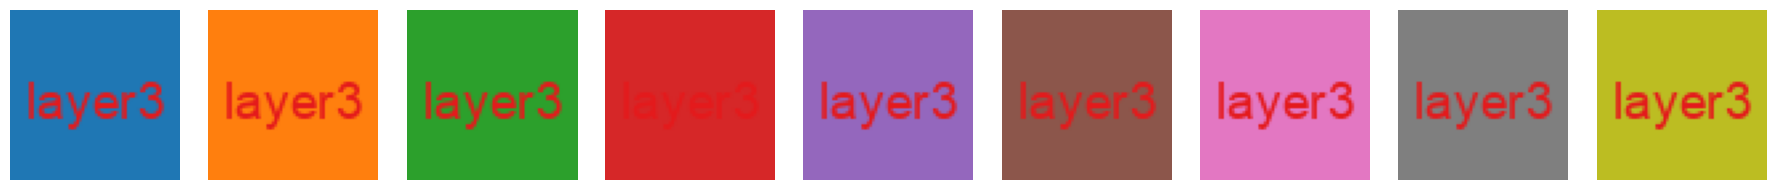

In [45]:
module = list(diffusion_spatial_features.keys())[-1]
batch_idx = 0

feature_maps = diffusion_spatial_features[module][batch_idx]

def display_feature_maps(feature_maps, scale=2):
    feature_maps_pil = [TF.to_pil_image(im.cpu()) for im in feature_maps]
    display_ims(feature_maps_pil, scale=scale)

display_feature_maps(feature_maps)

In [46]:
from text3d2video.backprojection import (
    aggregate_feature_texture,
    render_vert_features,
)
from text3d2video.rendering import make_rasterizer


vert_ft = aggregate_feature_texture(
    feature_maps,
    meshes.num_verts_per_mesh()[0],
    visible_vert_coords,
    visible_vert_indices,
)

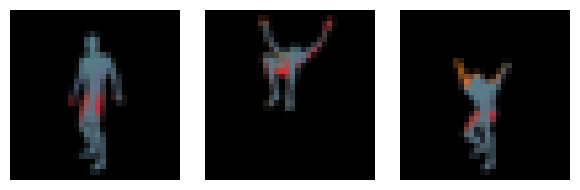

In [47]:
from torch import Tensor



indices = Tensor([0, 3, 1]).long()
raster_res = 500
res = 32

# rasterize all meshes
rasterizer = make_rasterizer(resolution=raster_res)
fragments = rasterizer(meshes, cameras=cameras)

meshes_chunk = meshes[indices]
cams_chunk = cameras[indices]

fragments_chunk = rasterizer(meshes_chunk, cameras=cams_chunk)

renders = render_vert_features(vert_ft, meshes_chunk, fragments_chunk, resolution=res)

display_feature_maps(renders)